# Testing baseline model with `CountVectorizer()`

## Load data

In [1]:
import pandas as pd
df = pd.read_csv('./data/train.csv')
X = df['text']
Y = df['suicide']

## Pre-processing

### WordVectorization with `CountVectorizer()`

In [2]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
vectorizer.fit(X)
X_set = vectorizer.transform(X)

In [3]:
print("Shape of X:", X_set.shape)
print("Shape of Y:", Y.shape)

Shape of X: (185650, 134440)
Shape of Y: (185650,)


## Building the baseline model

For testing purposes, we will use the Logistic Regression classifier `LogisticRegression()` with its default settings as our baseline model.

In [4]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(max_iter=10000)

## Evaluating the Baseline Model

### 5-fold Stratified Cross-validation

In [5]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

skfolds = StratifiedKFold(n_splits=5, shuffle=True, random_state=60)
accuracy_score_list, recall_score_list, precision_score_list, f1_score_list = [], [], [], []

for time, (train_index, test_index) in enumerate(skfolds.split(X_set, Y)):
    X_train, X_test = X_set[train_index], X_set[test_index]
    Y_train, Y_test = Y.iloc[train_index], Y.iloc[test_index]

    clf.fit(X_train, Y_train)
    y_pred = clf.predict(X_test)
    print(clf.n_iter_)

    # Evaluate model
    AccuracyScore = accuracy_score(Y_test, y_pred)
    RecallScore = recall_score(Y_test, y_pred)
    PrecisionScore = precision_score(Y_test, y_pred)
    F1Score = f1_score(Y_test, y_pred)

    # Add to lists
    accuracy_score_list.append(AccuracyScore)
    recall_score_list.append(RecallScore)
    precision_score_list.append(PrecisionScore)
    f1_score_list.append(F1Score)

    # Print the matrix
    print('Time: ', time + 1)
    print('\taccuracy_score: {:.4f}'.format(AccuracyScore))
    print('\trecall_score: {:.4f}'.format(RecallScore))
    print('\tprecision_score: {:.4f}'.format(PrecisionScore))
    print('\tf1_score: {:.4f}'.format(F1Score))

[700]
Time:  1
	accuracy_score: 0.9316
	recall_score: 0.9115
	precision_score: 0.9497
	f1_score: 0.9302
[772]
Time:  2
	accuracy_score: 0.9323
	recall_score: 0.9109
	precision_score: 0.9517
	f1_score: 0.9308
[563]
Time:  3
	accuracy_score: 0.9350
	recall_score: 0.9158
	precision_score: 0.9524
	f1_score: 0.9337
[633]
Time:  4
	accuracy_score: 0.9315
	recall_score: 0.9107
	precision_score: 0.9503
	f1_score: 0.9301
[785]
Time:  5
	accuracy_score: 0.9324
	recall_score: 0.9099
	precision_score: 0.9527
	f1_score: 0.9308


In [6]:
import numpy as np

# Print the average value of each matrix
print("Accuracy: {:.2%}".format(np.average(accuracy_score_list)))
print("Recall: {:.2%}".format(np.average(recall_score_list)))
print("Precision: {:.2%}".format(np.average(precision_score_list)))
print("F1_score: {:.2%}".format(np.average(f1_score_list)))

Accuracy: 93.26%
Recall: 91.18%
Precision: 95.13%
F1_score: 93.11%


## Save the model

In [7]:
import pickle

clf.fit(X_set, Y)

print(clf.n_iter_)

with open('./model/LR_count.pickle', 'wb') as f:
    pickle.dump(clf, f)

with open('./model/features.pkl', 'wb') as fw:
    pickle.dump(vectorizer.vocabulary_, fw)

[840]


using code below to load the fitted model:

``` python
with open('./model/LR_count.pickle', 'rb') as f:
    clf = pickle.load(f)
```

In [8]:
vocabulary = vectorizer.vocabulary_

print(clf.coef_[:, vocabulary['happy']])
print(clf.coef_[:, vocabulary['sad']])

[-0.0885195]
[-0.23324914]


In [9]:
n_feats_to_show = 10

# Flip the index so that values are keys and keys are values:
keys = vectorizer.vocabulary_.values()
values = vectorizer.vocabulary_.keys()
vocab_inverted = dict(zip(keys, values))

for c, weights_c in enumerate(clf.coef_):
    print(f'\nWeights for class {c}:\n')
    strongest_idxs = np.argsort(weights_c)[-n_feats_to_show:]

    for idx in strongest_idxs:
        print(f'{vocab_inverted[idx]} with weight {weights_c[idx]}')


Weights for class 0:

donei with weight 3.4841614817831075
doi with weight 3.6269333861349358
suicidei with weight 3.6496918409691963
myselfi with weight 3.8606802512099305
lifei with weight 3.9068399093850843
iti with weight 4.199884099873644
anymorei with weight 4.221535718460458
diei with weight 4.235475505918625
helpi with weight 4.662824388545299
mei with weight 4.814951364729974


## Test

In [10]:
df = pd.read_csv('./data/test.csv')
X = df['text']
Y = df['suicide']

In [11]:
X_test = vectorizer.transform(X)

lrc_preds = clf.predict_proba(X_test)

<Figure size 640x480 with 0 Axes>

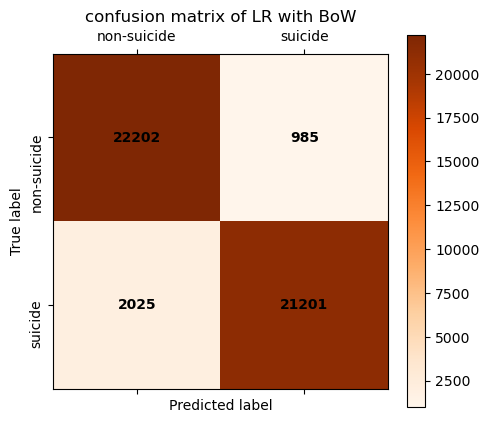

              precision    recall  f1-score   support

           0       0.92      0.96      0.94     23187
           1       0.96      0.91      0.93     23226

    accuracy                           0.94     46413
   macro avg       0.94      0.94      0.94     46413
weighted avg       0.94      0.94      0.94     46413



In [12]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

y_pred = lrc_preds.argmax(1)
cm = confusion_matrix(Y, y_pred)
plt.figure()
plt.matshow(cm, cmap=plt.cm.Oranges)
plt.colorbar(fraction=0.05)
for x in range(len(cm)):
    for y in range(len(cm)):
        plt.annotate(cm[x, y], xy=(y, x), horizontalalignment='center', verticalalignment='center', weight='heavy')

plt.xlabel('Predicted label')
plt.xticks([1, 0], ['suicide', 'non-suicide'])
plt.ylabel('True label')
plt.yticks([1, 0], ['suicide', 'non-suicide'], rotation=90)
plt.title('confusion matrix of LR with BoW')
plt.savefig('./img/cm_LR_C.jpg')
plt.show()

print(classification_report(Y, y_pred))

In [13]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(Y, lrc_preds[:, 1])
roc_auc = auc(fpr, tpr)

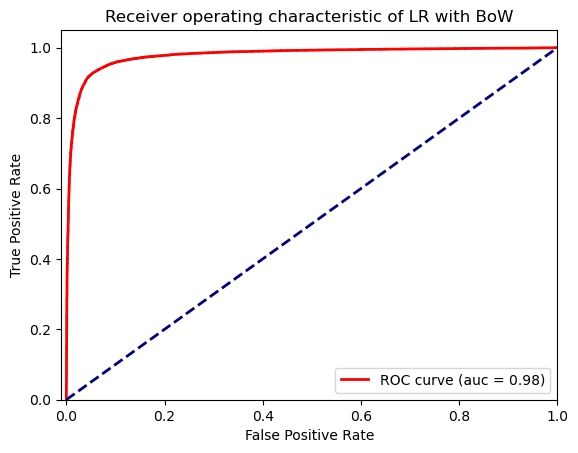

In [14]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='red',
         lw=lw, label='ROC curve (auc = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic of LR with BoW')
plt.legend(loc="lower right")
plt.savefig('./img/roc_LR_c.jpg')
plt.show()

## XAI

In [15]:
fps = []
fns = []

for i in range(len(Y)):
    if y_pred[i] != Y[i]:
        if y_pred[i] == 1:
            fps.append(X[i])
        else:
            fns.append(X[i])

In [31]:
import shap

explainer = shap.Explainer(clf, X_test)
shap_values = explainer(vectorizer.transform(fps))

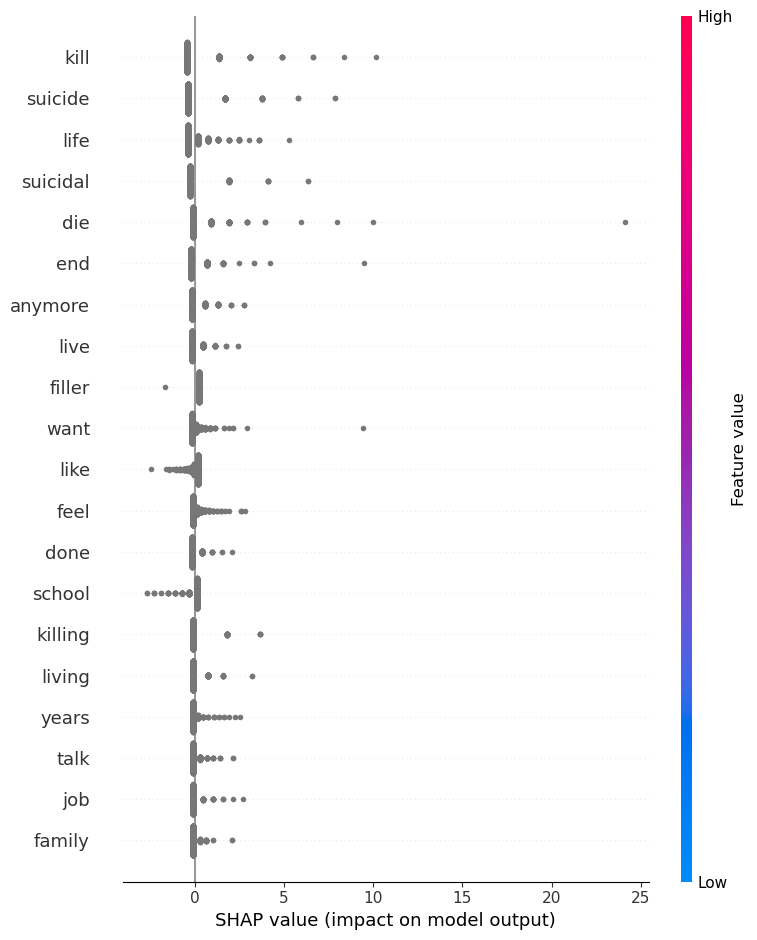

In [32]:
shap.summary_plot(shap_values, vectorizer.transform(fps), feature_names=vectorizer.get_feature_names_out())

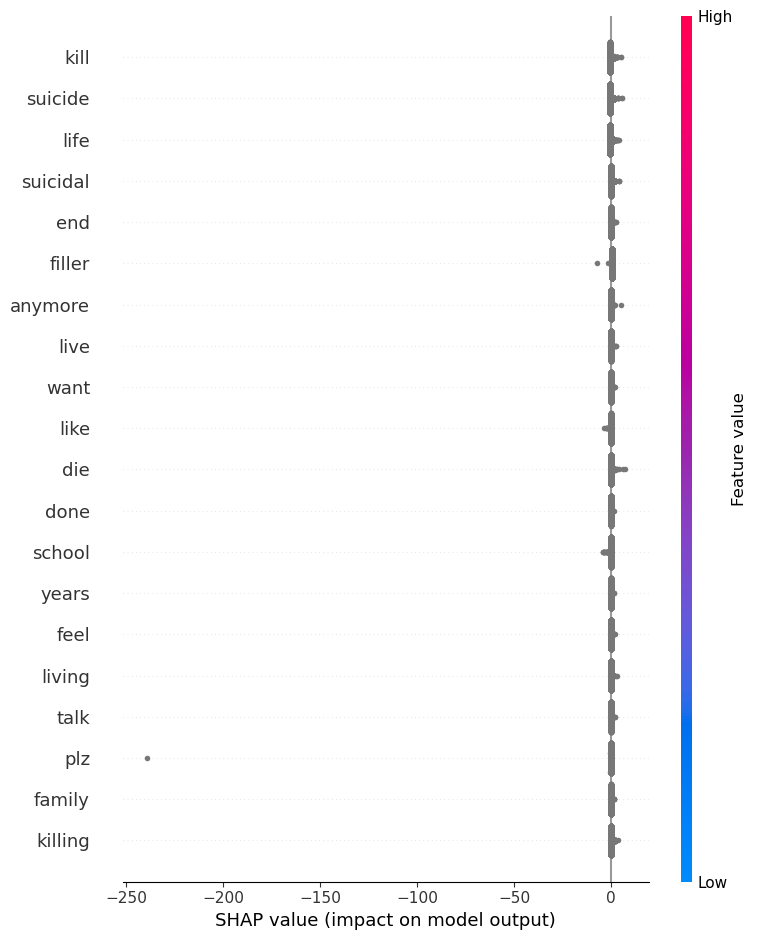

In [33]:
shap_values = explainer(vectorizer.transform(fns))
shap.summary_plot(shap_values, vectorizer.transform(fns), feature_names=vectorizer.get_feature_names_out())